## Training an MNIST classifier using AGT

### Intro

In this notebook, we'll train a classifier on the MNIST dataset using AGT (Abstract Gradient Training). AGT computes
bounds on the parameters of the classifier with respect to a given poisoning attack. This means that if even if our data
is poisoned by an adversary, the parameters of the model are guaranteed to lie within our bounds. This is then used to
compute a certified accuracy, which is the percentage of clean test data that the model is guaranteed to classify
correctly even under poisoning.

### Setup

Since multi-class classification settings are the most challenging settings for AGT, we can't handle large models or
train for many epochs. To make the setting easier, we'll first use PCA to reduce the dimensionality of the MNIST data
down to 32 dimensions. Then we'll train a simple linear classifier on this reduced data using AGT.

This setting limits us to consider only label-flipping attacks, since we are no longer using AGT with the original features. We assume that the original features are clean from poisoning and thus the PCA reduction is also safe.


In [1]:
%load_ext autoreload
%autoreload 2
import os
import copy

import torch
import torch.utils.data
import torchvision
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import abstract_gradient_training as agt

### 1. Load the data and reduce the dimensionality using PCA

In [2]:
# download the data
mnist_train = torchvision.datasets.MNIST(root='./.data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./.data', train=False, download=True)

# flatten the images, convert to numpy and normalize
train_imgs = mnist_train.data.flatten(start_dim=1).numpy() / 255.0
test_imgs = mnist_test.data.flatten(start_dim=1).numpy() / 255.0

# perform PCA with 32 components, and transform the data back to tensors
pca = PCA(n_components=32)
pca.fit_transform(train_imgs)
train_imgs_pca = torch.tensor(pca.transform(train_imgs), dtype=torch.float32)
test_imgs_pca = torch.tensor(pca.transform(test_imgs), dtype=torch.float32)

# form the datasets (the training dataloader will be created on the fly for each run due to seeding the shuffle)
batchsize = 60000
train_dataset = torch.utils.data.TensorDataset(train_imgs_pca, mnist_train.targets)
test_dataset = torch.utils.data.TensorDataset(test_imgs_pca, mnist_test.targets)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 2. Specify the AGT configuration and linear model

In [4]:
# configure the training parameters
nominal_config = agt.AGTConfig(
    fragsize=5000,
    learning_rate=5.0,
    lr_decay=1.0,
    lr_min=0.001,
    n_epochs=2,
    device="cuda:1",
    loss="cross_entropy",
    log_level="INFO",
)

[AGT] [WARNING ] [16:33:54] k=0 suffers from numerical instability in the bounds, consider using k > 0 or dtype double.


### 3. Train a linear classifier using AGT

In [5]:
# seed first before forming dataloaders and model so that we can reproduce the run the the sweep below
torch.manual_seed(0)
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
model = torch.nn.Sequential(torch.nn.Linear(32, 10)).to(nominal_config.device)

# configure the poisoning attack by modifying the original config
config = copy.deepcopy(nominal_config)
config.label_k_poison = 10

bounded_model = agt.bounded_models.IntervalBoundedModel(model)
agt.poison_certified_training(bounded_model, config, dl_train, dl_test)

[AGT] [INFO    ] [16:33:56] =================== Starting Poison Certified Training ===================
[AGT] [INFO    ] [16:33:56] Starting epoch 1
[AGT] [INFO    ] [16:33:57] Batch 1. Loss (accuracy): 0.088 <= 0.088 <= 0.088
[AGT] [WARNING ] [16:33:57] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [16:33:57] Starting epoch 2
[AGT] [INFO    ] [16:33:58] Batch 2. Loss (accuracy): 0.654 <= 0.674 <= 0.693
[AGT] [INFO    ] [16:33:58] Final Eval. Loss (accuracy): 0.645 <= 0.762 <= 0.841
[AGT] [INFO    ] [16:33:58] =================== Finished Poison Certified Training ===================


### 4. Run a sweep over the number of label flips in the poisoning attack

In [6]:
results_dir = ".results/"
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)


def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/mnist_poison_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        bounded_model = agt.bounded_models.IntervalBoundedModel(model)
        bounded_model.load_params(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(0)
        dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        bounded_model = agt.bounded_models.IntervalBoundedModel(model)
        agt.poison_certified_training(bounded_model, config, dl_train, dl_test)
        bounded_model.save_params(fname)
    # get nominal accuracy (on the Drusen class)
    accuracy = agt.test_metrics.test_accuracy(bounded_model, *next(iter(dl_test)))
    return accuracy

In [7]:
# run a sweep over the following parameters (k_poison and clip_gamma)
k_poisons = list(range(0, 101, 5))
clip_gammas = [float("inf"), 0.2, 0.1]

results = {}

config = copy.deepcopy(nominal_config)
config.log_level = "ERROR"

for gamma in clip_gammas:
    tmp_results = {}
    for k_poison in k_poisons:
        print(f"{gamma = }, {k_poison = }             ", end="\r")
        config.label_k_poison = k_poison
        config.clip_gamma = gamma
        tmp_results[k_poison] = run_with_config(config)
    results[gamma] = tmp_results

### 5. Plot the results of the sweep

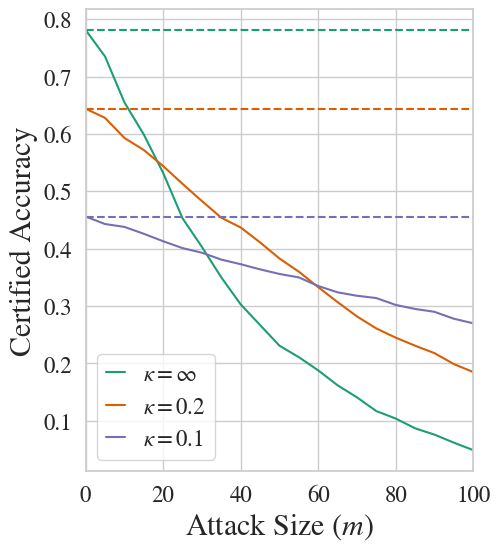

In [12]:
sns.set_theme(context="notebook", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
colors = iter(sns.color_palette(palette="Dark2", n_colors=12))
for gamma, r in results.items():
    nom_accs = [res[1] for res in r.values()]
    cert_accs = [res[0] for res in r.values()]
    k_poisons = list(r.keys())
    color = next(colors)
    ax.plot(k_poisons, nom_accs, linestyle="--", color=color)
    ax.plot(k_poisons, cert_accs, label=rf"$\kappa={gamma if gamma != float('inf') else '∞'}$", color=color)

plt.ylabel("Certified Accuracy", fontsize="large")
plt.xlabel("Attack Size ($m$)", fontsize="large")
plt.legend(handlelength=0.8)
plt.xlim(0, max(k_poisons))
plt.show()